In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Prediction of Lung Disease and Patient Followups Using Swin Transformer and Vision Transformer**

**Importing Libraries**

Importing all the necessary libraries to do Data manipulation, Model building, Training and Evaluation.

In [1]:
import os
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import torch.nn as nn
from PIL import Image
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset
from torchvision.models import swin_t
from torchvision.models import vit_b_16
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix


torch.manual_seed(42)

Setting the device as GPU for better processing of Deep learning models. If GPU is not available setting device to CPU.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

**Loading the Dataset**

Here, we load the dataset from the provided home directory and inspecting the structure.

In [3]:
data_dir = "/kaggle/input/data"
data_path = os.path.join(data_dir, 'Data_Entry_2017.csv')
data = pd.read_csv(data_path)
data.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


**Data Preprocessing**

The dataset is filtered to include only the relevant features in future steps.

The features included were:
* Image Index
* Finding Labels
* Follow-up #
* Patient Id
* Patient Age
* Patient Gender

And also checking the statistical properties of the above features.

In [4]:
data= data[['Image Index','Finding Labels','Follow-up #','Patient ID','Patient Age','Patient Gender']]


Checking the summary of the dataset using Info() method.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Image Index     112120 non-null  object
 1   Finding Labels  112120 non-null  object
 2   Follow-up #     112120 non-null  int64 
 3   Patient ID      112120 non-null  int64 
 4   Patient Age     112120 non-null  int64 
 5   Patient Gender  112120 non-null  object
dtypes: int64(3), object(3)
memory usage: 5.1+ MB


Checking for the Missing values in the dataset.

In [6]:
data.isna().sum()

Image Index       0
Finding Labels    0
Follow-up #       0
Patient ID        0
Patient Age       0
Patient Gender    0
dtype: int64

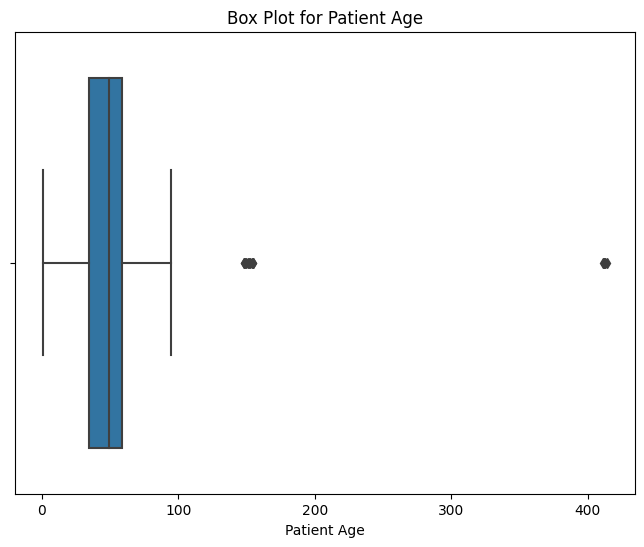

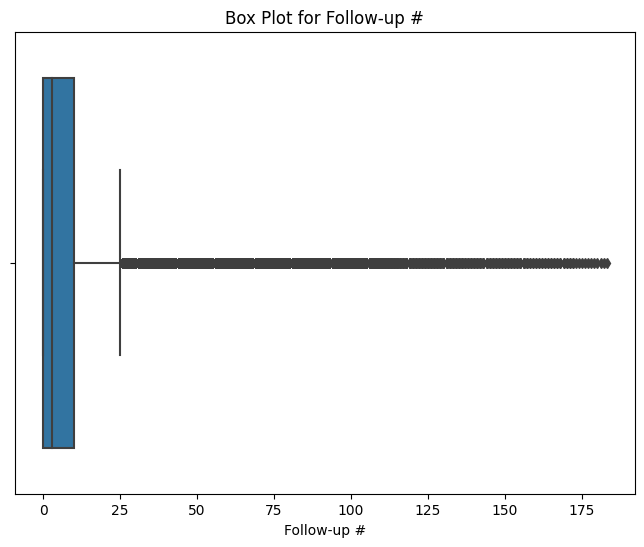

In [7]:
numerical_columns = ['Patient Age', 'Follow-up #']
for column in numerical_columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=data[column])
    plt.title(f'Box Plot for {column}')
    plt.xlabel(column)
    plt.show()

**Data Visualization**

Creating a Histogram and Kernal Density Estimate plot for the patient Age feature to understand the overall distribution patient ages and to identify the anomalies in the age data.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


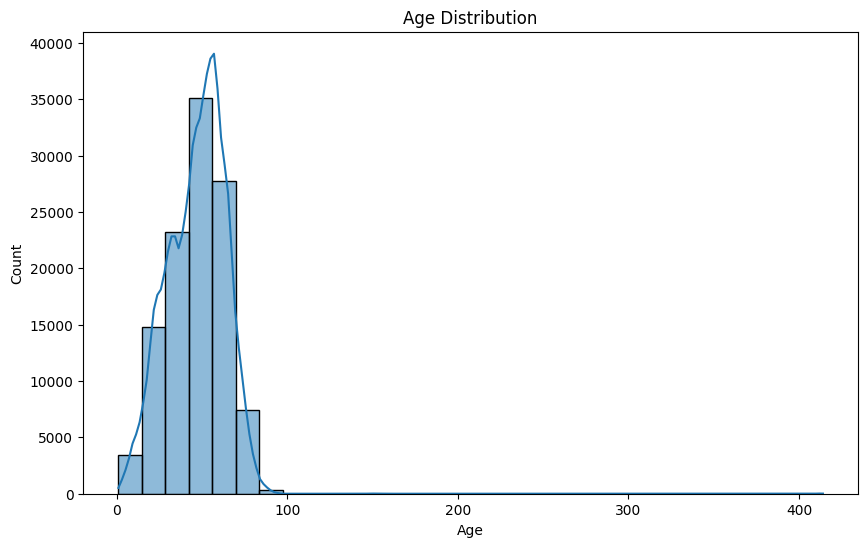

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(data['Patient Age'], bins=30, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

In [9]:
data.describe()

,Follow-up #,Patient ID,Patient Age
count,112120.000000,112120.000000,112120.000000
mean,8.573751,14346.381743,46.901463
std,15.406320,8403.876972,16.839923
min,0.000000,1.000000,1.000000
25%,0.000000,7310.750000,35.000000
50%,3.000000,13993.000000,49.000000
75%,10.000000,20673.000000,59.000000
max,183.000000,30805.000000,414.000000


In [12]:
q1, q3 = data['Patient Age'].quantile(0.25), data['Patient Age'].quantile(0.75)
iqr = q3 - q1
lower_bound, upper_bound = q1 - 1.5 * iqr, q3 + 1.5 * iqr
data['Patient Age'] = np.where((data['Patient Age'] < lower_bound) | (data['Patient Age'] > upper_bound), 
                               data['Patient Age'].median(), data['Patient Age'])
missing_labels = data['Follow-up #'].isna().sum()
def update_follow_up(df):
    df = df.sort_values(by=['Patient ID', 'Image Index'])
    for patient_id, patient_data in df.groupby('Patient ID'):
        previous_labels = set()  
        follow_up_counter = 1      
        for index, row in patient_data.iterrows():
            current_labels = set(row['Finding Labels'].split('|'))
            
            if 'No findings' in current_labels:
               df.at[index, 'Follow-up #'] = 1
            else:
                if previous_labels and not current_labels.issubset(previous_labels):
                    follow_up_counter += 1  
                df.at[index, 'Follow-up #'] = follow_up_counter
            previous_labels = current_labels
    return df
data = update_follow_up(data)
print(data.head())
print(data.describe())

        Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            1           1   
1  00000001_001.png  Cardiomegaly|Emphysema            2           1   
2  00000001_002.png   Cardiomegaly|Effusion            3           1   
3  00000002_000.png              No Finding            1           2   
4  00000003_000.png                  Hernia            1           3   

   Patient Age Patient Gender  
0         58.0              M  
1         58.0              M  
2         58.0              M  
3         81.0              M  
4         81.0              F  
         Follow-up #     Patient ID    Patient Age
count  112120.000000  112120.000000  112120.000000
mean        5.973725   14346.381743      46.872877
std         9.856034    8403.876972      16.596987
min         1.000000       1.000000       1.000000
25%         1.000000    7310.750000      35.000000
50%         2.000000   13993.000000      49.000000
75%         6.0000

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


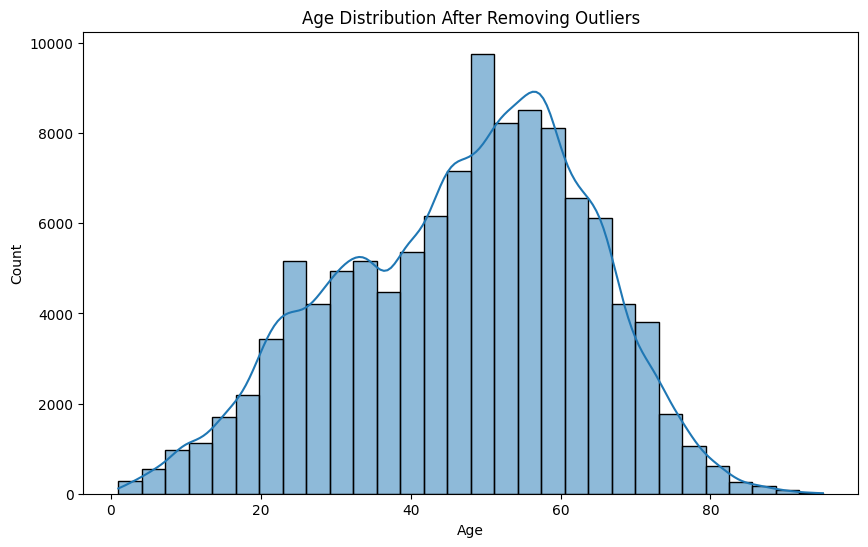

In [14]:
plt.figure(figsize=(10, 6))
sns.histplot(data['Patient Age'], bins=30, kde=True)
plt.title('Age Distribution After Removing Outliers')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

Text(0, 0.5, 'Number of Patients')

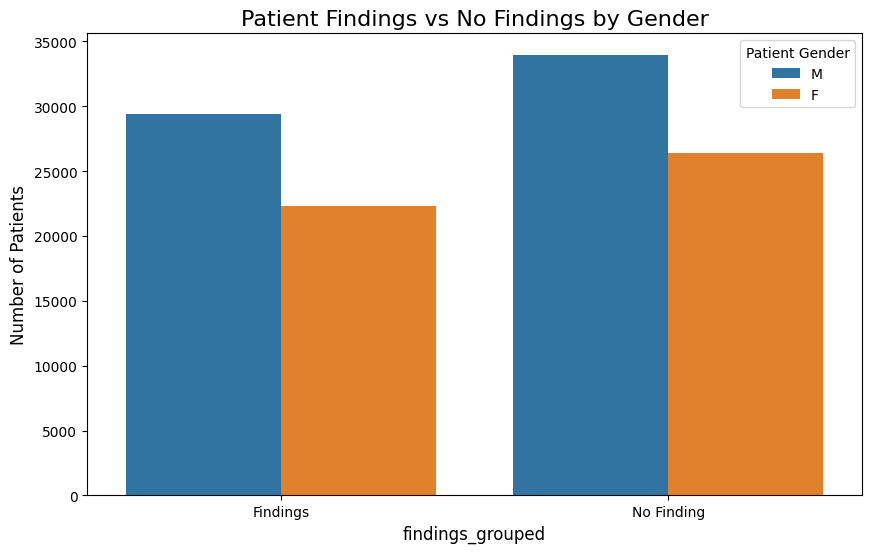

In [15]:
data['findings_grouped'] = data['Finding Labels'].apply(
    lambda x: 'Findings' if x != 'No Finding' else 'No Finding'
)
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='findings_grouped', hue='Patient Gender')
plt.title('Patient Findings vs No Findings by Gender', fontsize=16)
plt.xlabel('findings_grouped', fontsize=12)
plt.ylabel('Number of Patients', fontsize=12)

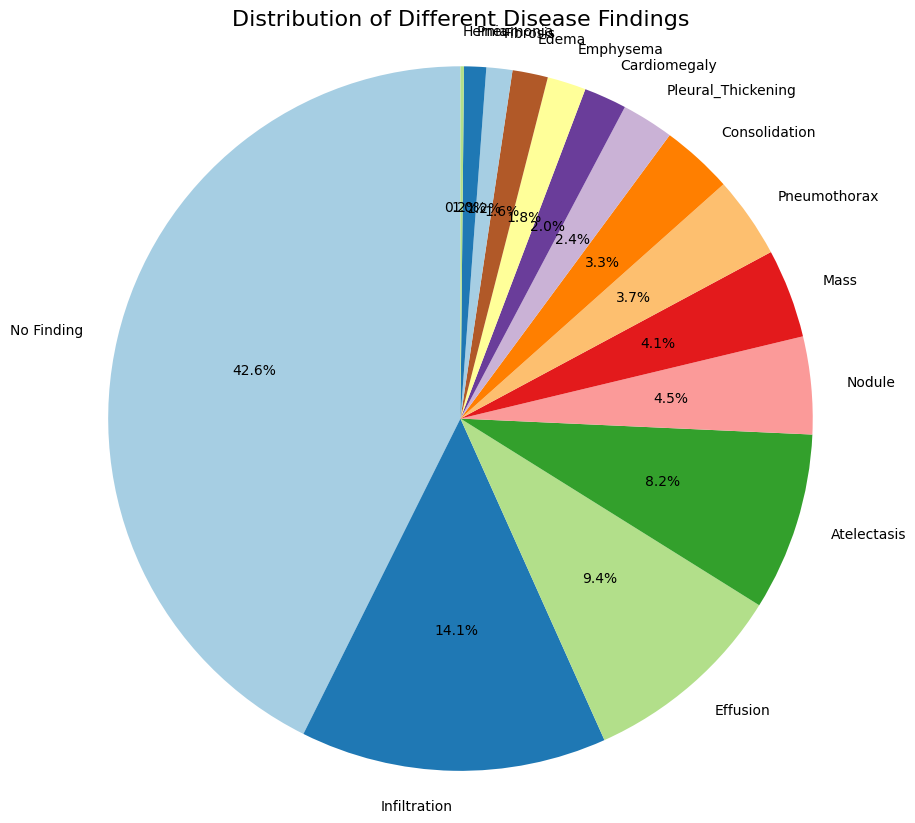

In [16]:
split_findings = data['Finding Labels'].str.split('|', expand=True).stack()
findings_count = split_findings.value_counts()
plt.figure(figsize=(10, 10))
plt.pie(findings_count, labels=findings_count.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Distribution of Different Disease Findings', fontsize=16)
plt.axis('equal')
plt.show()

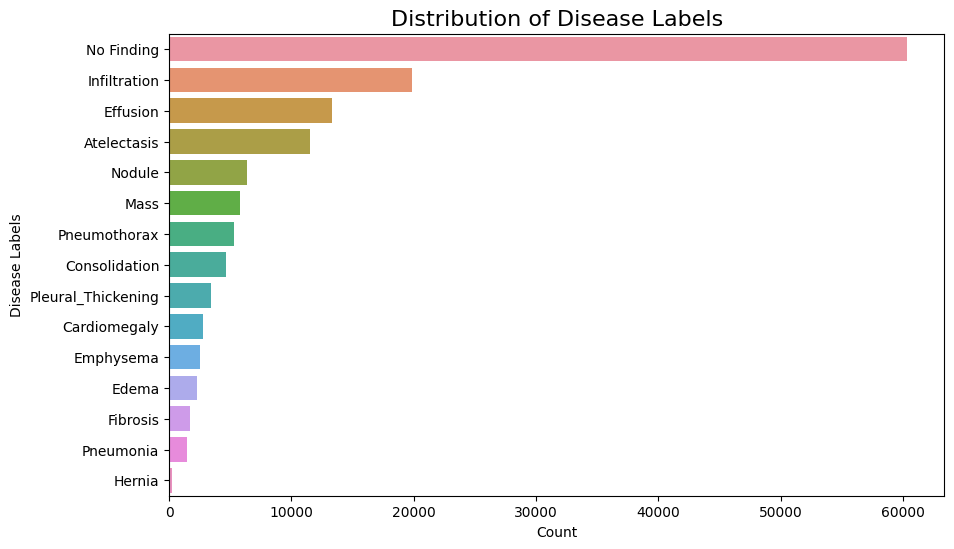

In [17]:
split_labels = split_findings.reset_index(level=1, drop=True).rename('Disease_Label')
data_split = data.join(split_labels)
plt.figure(figsize=(10, 6))
sns.countplot(y='Disease_Label', data=data_split, order=data_split['Disease_Label'].value_counts().index)
plt.title('Distribution of Disease Labels', fontsize=16)
plt.xlabel('Count')
plt.ylabel('Disease Labels')
plt.show()

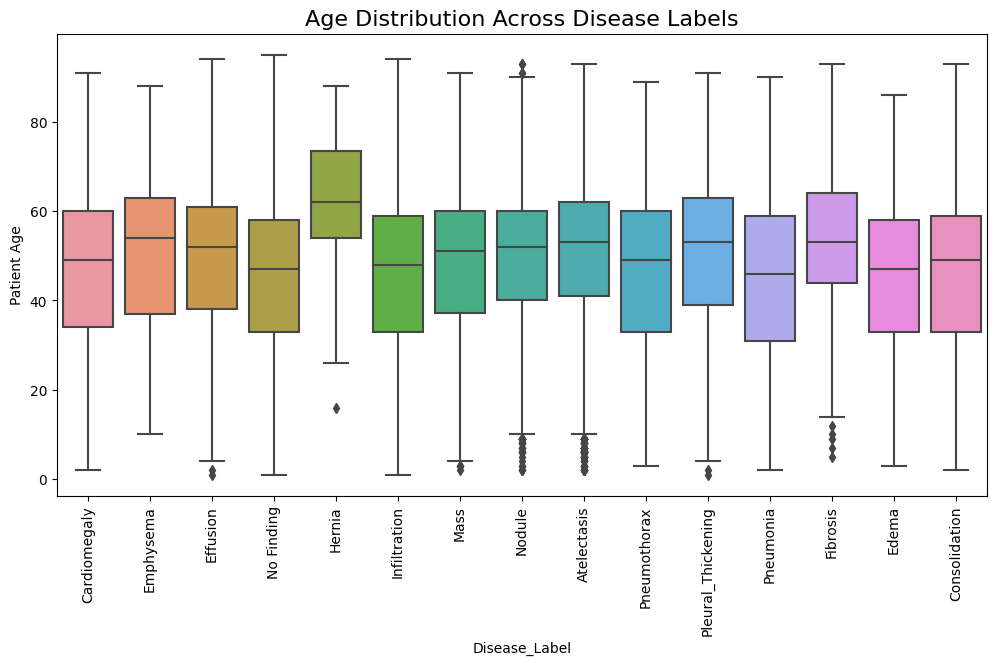

In [18]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Disease_Label', y='Patient Age', data=data_split)
plt.title('Age Distribution Across Disease Labels', fontsize=16)
plt.xticks(rotation=90)
plt.show()

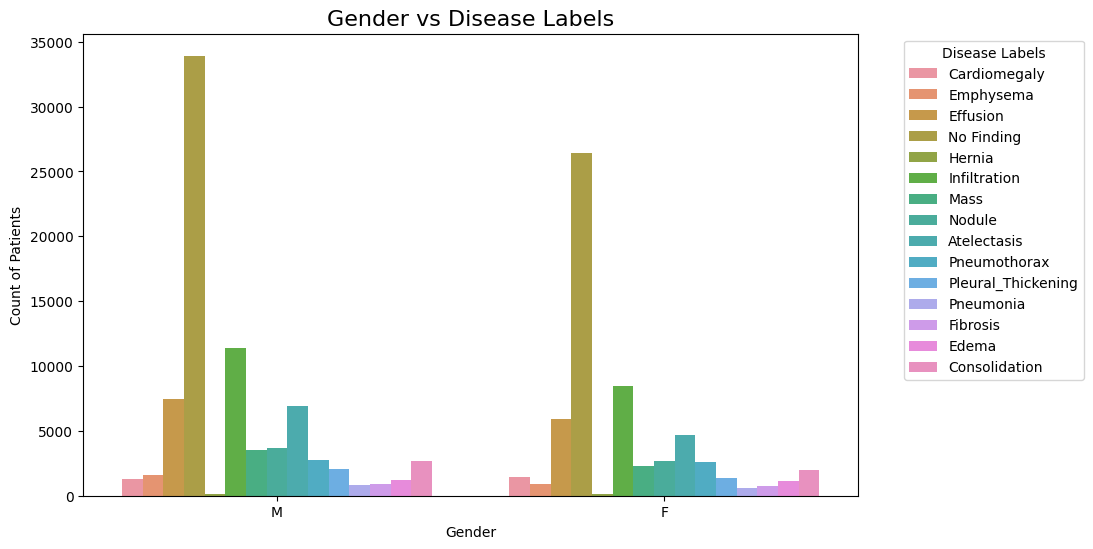

In [19]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data_split, x='Patient Gender', hue='Disease_Label', order=data_split['Patient Gender'].value_counts().index)
plt.title('Gender vs Disease Labels', fontsize=16)
plt.xlabel('Gender')
plt.ylabel('Count of Patients')
plt.legend(title='Disease Labels', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [20]:
scaler = StandardScaler()
data[['Follow-up #', 'Patient Age']] = scaler.fit_transform(data[['Follow-up #', 'Patient Age']])
data['Patient Gender'] = data['Patient Gender'].map({'M': 0, 'F': 1})
unique_labels = set(label for sublist in data['Finding Labels'].str.split('|') for label in sublist)
label_map = {label: idx for idx, label in enumerate(unique_labels)}
print(label_map)

{'Infiltration': 0, 'Pneumonia': 1, 'Emphysema': 2, 'Mass': 3, 'Pneumothorax': 4, 'Fibrosis': 5, 'Atelectasis': 6, 'No Finding': 7, 'Hernia': 8, 'Pleural_Thickening': 9, 'Cardiomegaly': 10, 'Nodule': 11, 'Edema': 12, 'Consolidation': 13, 'Effusion': 14}


In [21]:
class NIH_Chest_Xray_Dataset(Dataset):
    def __init__(self, data_dir, dataframe, label_map, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.dataframe = dataframe
        self.label_map = label_map
        self.image_paths = []
        self.labels = []
        self.follow_up = []
        self.age = []
        self.gender = []
        for index, row in dataframe.iterrows():
            img_name = row['Image Index']
            found_image = False
            for i in range(1, 13):
                folder_name = f'images_{str(i).zfill(3)}/images'
                image_path = os.path.join(self.data_dir, folder_name, img_name)
                if os.path.isfile(image_path):
                    found_image = True
                    self.image_paths.append(image_path)
                    self.labels.append(row['Finding Labels'].split("|"))
                    self.follow_up.append(row['Follow-up #'])
                    self.age.append(row['Patient Age'])
                    self.gender.append(row['Patient Gender'])
                    break
            if not found_image:
                print(f"Image not found for row {index}: {img_name}")
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        labels = self.labels[idx]
        follow_up = self.follow_up[idx]
        age = self.age[idx]
        gender = self.gender[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        num_labels = len(self.label_map)
        binary_label = torch.zeros(num_labels)
        for label in labels:
            binary_label[self.label_map[label]] = 1
        age_gender = torch.tensor([age, gender], dtype=torch.float32)
        return img, binary_label, torch.tensor(follow_up, dtype=torch.float32), age_gender
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [22]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)
print("Train set size:", len(train_df))
print("Test set size:", len(test_df))
train_dataset = NIH_Chest_Xray_Dataset(data_dir, train_df, label_map, transform=transform)
test_dataset = NIH_Chest_Xray_Dataset(data_dir, test_df, label_map, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
print("Train dataloader length:", len(train_dataloader))
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)
print("Test dataloader length:", len(test_dataloader))

Train set size: 89696
Test set size: 22424
Train dataloader length: 2803
Test dataloader length: 1402


In [23]:
class MultiTaskViTWithMeta(nn.Module):
    def __init__(self, num_classes):
        super(MultiTaskViTWithMeta, self).__init__()
        self.backbone = vit_b_16(weights='IMAGENET1K_V1')
        self.backbone.heads = nn.Identity()
        self.meta_fc = nn.Sequential(
            nn.Linear(2, 64),  # Increase complexity
            nn.ReLU(),
            nn.BatchNorm1d(64),  # Add normalization
            nn.Linear(64, 32),
            nn.ReLU()
        )

        # Shared feature layer
        self.shared_fc = nn.Sequential(
            nn.Linear(768 + 32, 512),  # Combine features from backbone and metadata
            nn.ReLU(),
            nn.Dropout(0.3)  # Add regularization
        )

        # Classification head
        self.classification_head = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

        # Regression head
        self.regression_head = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1)
        )

    def forward(self, x, meta):
        # Pass through backbone
        x = self.backbone(x)
        
        # Process metadata
        meta_out = self.meta_fc(meta)
        
        # Combine backbone and metadata outputs
        x = torch.cat((x, meta_out), dim=1)
        
        # Shared processing
        shared_out = self.shared_fc(x)
        
        # Separate into classification and regression outputs
        class_out = self.classification_head(shared_out)
        reg_out = self.regression_head(shared_out)
        return class_out, reg_out
class MultiTaskSwinWithMeta(nn.Module):
    def __init__(self, num_classes):
        super(MultiTaskSwinWithMeta, self).__init__()
        self.backbone = swin_t(weights='DEFAULT')
        self.backbone.head = nn.Identity()  
        self.meta_fc = nn.Sequential(
            nn.Linear(2, 64),  
            nn.ReLU(),
            nn.BatchNorm1d(64),  # Add normalization
            nn.Linear(64, 32),
            nn.ReLU()
        )
        # Shared feature layer
        self.shared_fc = nn.Sequential(
            nn.Linear(768 + 32, 512),  # Combine features from backbone and metadata
            nn.ReLU(),
            nn.Dropout(0.3)  # Add regularization
        )
        # Classification head
        self.classification_head = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
        # Regression head
        self.regression_head = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1)
        )
    def forward(self, x, meta):
        # Pass through backbone
        x = self.backbone(x)
        # Process metadata
        meta_out = self.meta_fc(meta)
        # Combine backbone and metadata outputs
        x = torch.cat((x, meta_out), dim=1)
        # Shared processing
        shared_out = self.shared_fc(x)
        # Separate into classification and regression outputs
        class_out = self.classification_head(shared_out)
        reg_out = self.regression_head(shared_out)
        return class_out, reg_out
num_classes = len(label_map)
vit_model = MultiTaskViTWithMeta(num_classes).to(device)
swin_model = MultiTaskSwinWithMeta(num_classes).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:04<00:00, 74.3MB/s] 
Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth
100%|██████████| 108M/108M [00:00<00:00, 128MB/s]  


In [24]:
classification_loss_fn = nn.BCEWithLogitsLoss()
regression_loss_fn = nn.MSELoss()
vit_optimizer = optim.Adam(vit_model.parameters(), lr=1e-4)
swin_optimizer = optim.Adam(swin_model.parameters(), lr=1e-4)


In [25]:
num_epochs = 10
for epoch in range(num_epochs):
    vit_model.train()
    swin_model.train()
    vit_running_loss = 0.0
    swin_running_loss = 0.0
    for images, labels, follow_up, meta in tqdm(train_dataloader):
        images, labels, follow_up, meta = images.to(device), labels.to(device), follow_up.to(device), meta.to(device)
        vit_optimizer.zero_grad()
        swin_optimizer.zero_grad()
        vit_class_out, vit_reg_out = vit_model(images, meta)
        vit_class_loss = classification_loss_fn(vit_class_out, labels)
        vit_reg_loss = regression_loss_fn(vit_reg_out.squeeze(), follow_up)
        vit_loss = vit_class_loss + vit_reg_loss
        vit_loss.backward()
        vit_optimizer.step()
        vit_running_loss += vit_loss.item()
        swin_class_out, swin_reg_out = swin_model(images, meta)
        swin_class_loss = classification_loss_fn(swin_class_out, labels)
        swin_reg_loss = regression_loss_fn(swin_reg_out.squeeze(), follow_up)
        swin_loss = swin_class_loss + swin_reg_loss
        swin_loss.backward()
        swin_optimizer.step()
        swin_running_loss += swin_loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, ViT Loss: {vit_running_loss/len(train_dataloader)}, Swin Loss: {swin_running_loss/len(train_dataloader)}")

100%|██████████| 2803/2803 [41:10<00:00,  1.13it/s]


Epoch 1/10, ViT Loss: 0.999768540013317, Swin Loss: 0.9422869641377677


100%|██████████| 2803/2803 [41:14<00:00,  1.13it/s]


Epoch 2/10, ViT Loss: 0.9454464944205112, Swin Loss: 0.8388352698985058


100%|██████████| 2803/2803 [41:15<00:00,  1.13it/s]


Epoch 3/10, ViT Loss: 0.9226666351768998, Swin Loss: 0.7914259233327581


100%|██████████| 2803/2803 [41:14<00:00,  1.13it/s]


Epoch 4/10, ViT Loss: 0.8973996790815072, Swin Loss: 0.7743575680247384


100%|██████████| 2803/2803 [41:17<00:00,  1.13it/s]


Epoch 5/10, ViT Loss: 0.8708323690238868, Swin Loss: 0.7285878777110573


100%|██████████| 2803/2803 [41:16<00:00,  1.13it/s]


Epoch 6/10, ViT Loss: 0.8516211662437505, Swin Loss: 0.7321983148827963


100%|██████████| 2803/2803 [41:14<00:00,  1.13it/s]


Epoch 7/10, ViT Loss: 0.8245939343444714, Swin Loss: 0.7035919278647447


100%|██████████| 2803/2803 [41:14<00:00,  1.13it/s]


Epoch 8/10, ViT Loss: 0.8095259761336102, Swin Loss: 0.6739650435620786


100%|██████████| 2803/2803 [41:14<00:00,  1.13it/s]


Epoch 9/10, ViT Loss: 0.7804015657591726, Swin Loss: 0.6562750707066488


100%|██████████| 2803/2803 [41:15<00:00,  1.13it/s]

Epoch 10/10, ViT Loss: 0.7657975831915981, Swin Loss: 0.6454686949370463


In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error
import numpy as np
import torch
from tqdm import tqdm
from scipy import stats

# Function to calculate multi-label classification precision, recall, and F1
def evaluate_classification_metrics(preds, labels):
    precision = precision_score(labels, preds, average='macro', zero_division=1)
    recall = recall_score(labels, preds, average='macro', zero_division=1)
    f1 = f1_score(labels, preds, average='macro', zero_division=1)
    return precision, recall, f1

# Function to calculate AUC-ROC for multi-class/multi-label classification
def evaluate_auc(all_labels, all_preds, label_map):
    auc_scores = []
    for i in range(len(label_map)):
        try:
            auc = roc_auc_score(all_labels[:, i], all_preds[:, i])
            auc_scores.append(auc)
        except ValueError:
            print(f"Warning: AUC calculation failed for label index {i}. Possibly only one class present.")
            auc_scores.append(0.0)  # Append 0.0 or any appropriate default for failed AUC calculation
    mean_auc = np.mean(auc_scores)
    return mean_auc

# Function to calculate regression metrics (RMSE)
def evaluate_regression(preds, labels):
    mse = mean_squared_error(labels, preds)
    rmse = np.sqrt(mse)
    return rmse

# Initialize lists to hold metrics for both models
vit_class_metrics = []
vit_reg_metrics = []
swin_class_metrics = []
swin_reg_metrics = []

# Variables to accumulate predictions and true values for AUC calculation and regression metrics
all_labels = []
all_vit_preds = []
all_swin_preds = []
all_vit_reg_preds = []
all_swin_reg_preds = []
all_follows = []

# Set models to evaluation mode
vit_model.eval()
swin_model.eval()

# Assuming `test_dataloader` provides batches of (images, labels, follow_up, meta)
with torch.no_grad():
    for images, labels, follow_up, meta in tqdm(test_dataloader):
        images, labels, follow_up, meta = images.to(device), labels.to(device), follow_up.to(device), meta.to(device)

        # ViT model predictions
        vit_class_out, vit_reg_out = vit_model(images, meta)
        vit_class_preds = (torch.sigmoid(vit_class_out) > 0.5).cpu().numpy()  # Binarize predictions

        # Store ViT classification and regression metrics
        vit_class_metrics.append(evaluate_classification_metrics(vit_class_preds, labels.cpu().numpy()))
        vit_reg_metrics.append(evaluate_regression(vit_reg_out.squeeze().cpu().numpy(), follow_up.cpu().numpy()))

        # Swin model predictions
        swin_class_out, swin_reg_out = swin_model(images, meta)
        swin_class_preds = (torch.sigmoid(swin_class_out) > 0.5).cpu().numpy()  # Binarize predictions

        # Store Swin classification and regression metrics
        swin_class_metrics.append(evaluate_classification_metrics(swin_class_preds, labels.cpu().numpy()))
        swin_reg_metrics.append(evaluate_regression(swin_reg_out.squeeze().cpu().numpy(), follow_up.cpu().numpy()))

        # Store for AUC calculation and regression outputs
        all_labels.append(labels.cpu().numpy())
        all_vit_preds.append(torch.sigmoid(vit_class_out).cpu().numpy())  # For AUC from ViT predictions
        all_swin_preds.append(torch.sigmoid(swin_class_out).cpu().numpy()) # For AUC from Swin predictions
        all_vit_reg_preds.append(vit_reg_out.squeeze().cpu().numpy())
        all_swin_reg_preds.append(swin_reg_out.squeeze().cpu().numpy())
        all_follows.append(follow_up.cpu().numpy())

# Convert lists to NumPy arrays for further processing
all_labels = np.vstack(all_labels)
all_vit_preds = np.vstack(all_vit_preds)
all_swin_preds = np.vstack(all_swin_preds)
all_vit_reg_preds = np.concatenate(all_vit_reg_preds)
all_swin_reg_preds = np.concatenate(all_swin_reg_preds)
all_follows = np.concatenate(all_follows)

# Calculate the average classification metrics for both models
vit_class_metrics_avg = np.mean(vit_class_metrics, axis=0)
vit_reg_metrics_avg = np.mean(vit_reg_metrics)
swin_class_metrics_avg = np.mean(swin_class_metrics, axis=0)
swin_reg_metrics_avg = np.mean(swin_reg_metrics)

# Print the classification and regression results for both models
print("ViT Model - Classification ( Precision, Recall, F1):", vit_class_metrics_avg)
print("ViT Model - Regression (RMSE):", vit_reg_metrics_avg)
print("Swin Model - Classification ( Precision, Recall, F1):", swin_class_metrics_avg)
print("Swin Model - Regression (RMSE):", swin_reg_metrics_avg)

# Calculate AUC-ROC for multi-label classification
mean_auc_vit = evaluate_auc(all_labels, all_vit_preds, label_map)  # assuming label_map exists
mean_auc_swin = evaluate_auc(all_labels, all_swin_preds, label_map)

print(f"ViT Model Mean AUC-ROC: {mean_auc_vit:.4f}")
print(f"Swin Model Mean AUC-ROC: {mean_auc_swin:.4f}")

# Calculate Mean Squared Error (MSE) for Regression
mse_vit = mean_squared_error(all_follows, all_vit_reg_preds)
mse_swin = mean_squared_error(all_follows, all_swin_reg_preds)

print(f"ViT Model Mean Regression MSE: {mse_vit:.4f}")
print(f"Swin Model Mean Regression MSE: {mse_swin:.4f}")

100%|██████████| 1402/1402 [04:05<00:00,  5.72it/s]


ViT Model - Classification ( Precision, Recall, F1): [0.97709909 0.55067596 0.544597  ]
ViT Model - Regression (RMSE): 0.66656435
Swin Model - Classification ( Precision, Recall, F1): [0.97747388 0.55172115 0.54655626]
Swin Model - Regression (RMSE): 0.603581
ViT Model Mean AUC-ROC: 0.7099
Swin Model Mean AUC-ROC: 0.7301
ViT Model Mean Regression MSE: 0.5809
Swin Model Mean Regression MSE: 0.4516


In [31]:
# Function to calculate multi-label classification precision, recall, and F1
def evaluate_classification_metrics(preds, labels):
    precision = precision_score(labels, preds, average='macro', zero_division=1)
    recall = recall_score(labels, preds, average='macro', zero_division=1)
    f1 = f1_score(labels, preds, average='macro', zero_division=1)
    return precision, recall, f1

# Function to calculate AUC-ROC for multi-class/multi-label classification
def evaluate_auc(all_labels, all_preds, label_map):
    auc_scores = []
    for i in range(len(label_map)):
        try:
            auc = roc_auc_score(all_labels[:, i], all_preds[:, i])
            auc_scores.append(auc)
        except ValueError:
            print(f"Warning: AUC calculation failed for label index {i}. Possibly only one class present.")
            auc_scores.append(0.0)  # Append 0.0 or any appropriate default for failed AUC calculation
    mean_auc = np.mean(auc_scores)
    return mean_auc

# Function to calculate regression metrics (RMSE)
def evaluate_regression(preds, labels):
    mse = mean_squared_error(labels, preds)
    rmse = np.sqrt(mse)
    return rmse

# Number of repetitions for hypothesis testing
num_repeats = 3  # Change this to however many repetitions you need

# Initialize lists to hold metrics for both models
all_vit_class_metrics = []
all_vit_reg_metrics = []
all_swin_class_metrics = []
all_swin_reg_metrics = []
all_auc_vit = []
all_auc_swin = []
all_mse_vit = []
all_mse_swin = []

# Run the evaluation multiple times for hypothesis testing
for repeat in range(num_repeats):
    print(f"\n--- Epoch {repeat + 1}/{num_repeats} ---")
    
    # Variables to accumulate predictions and true values for AUC calculation
    all_labels = []
    all_vit_preds = []
    all_swin_preds = []
    all_vit_reg_preds = []
    all_swin_reg_preds = []
    all_follows = []
    
    # Set models to evaluation mode
    vit_model.eval()
    swin_model.eval()

    # Assuming `test_dataloader` provides batches of (images, labels, follow_up, meta)
    with torch.no_grad():
        for images, labels, follow_up, meta in tqdm(test_dataloader):
            images, labels, follow_up, meta = images.to(device), labels.to(device), follow_up.to(device), meta.to(device)

            # ViT model predictions
            vit_class_out, vit_reg_out = vit_model(images, meta)
            vit_class_preds = (torch.sigmoid(vit_class_out) > 0.5).cpu().numpy()  # Binarize predictions

            # Store ViT classification and regression metrics
            all_vit_class_metrics.append(evaluate_classification_metrics(vit_class_preds, labels.cpu().numpy()))
            all_vit_reg_metrics.append(evaluate_regression(vit_reg_out.squeeze().cpu().numpy(), follow_up.cpu().numpy()))

            # Swin model predictions
            swin_class_out, swin_reg_out = swin_model(images, meta)
            swin_class_preds = (torch.sigmoid(swin_class_out) > 0.5).cpu().numpy()  # Binarize predictions

            # Store Swin classification and regression metrics
            all_swin_class_metrics.append(evaluate_classification_metrics(swin_class_preds, labels.cpu().numpy()))
            all_swin_reg_metrics.append(evaluate_regression(swin_reg_out.squeeze().cpu().numpy(), follow_up.cpu().numpy()))

            # Store for AUC calculation and regression outputs
            all_labels.append(labels.cpu().numpy())
            all_vit_preds.append(torch.sigmoid(vit_class_out).cpu().numpy())  # For AUC from ViT predictions
            all_swin_preds.append(torch.sigmoid(swin_class_out).cpu().numpy()) # For AUC from Swin predictions
            all_vit_reg_preds.append(vit_reg_out.squeeze().cpu().numpy())
            all_swin_reg_preds.append(swin_reg_out.squeeze().cpu().numpy())
            all_follows.append(follow_up.cpu().numpy())

    # Convert lists to NumPy arrays for further processing
    all_labels = np.vstack(all_labels)
    all_vit_preds = np.vstack(all_vit_preds)
    all_swin_preds = np.vstack(all_swin_preds)
    all_vit_reg_preds = np.concatenate(all_vit_reg_preds)
    all_swin_reg_preds = np.concatenate(all_swin_reg_preds)
    all_follows = np.concatenate(all_follows)

    # Calculate the average classification metrics for both models
    vit_class_metrics = np.mean(all_vit_class_metrics, axis=0)
    vit_reg_metrics = np.mean(all_vit_reg_metrics)
    swin_class_metrics = np.mean(all_swin_class_metrics, axis=0)
    swin_reg_metrics = np.mean(all_swin_reg_metrics)

    # Store the results of this repeat for analysis
    all_vit_class_metrics.append(vit_class_metrics)
    all_vit_reg_metrics.append(vit_reg_metrics)
    all_swin_class_metrics.append(swin_class_metrics)
    all_swin_reg_metrics.append(swin_reg_metrics)

    # Calculate AUC-ROC for multi-label classification
    mean_auc_vit = evaluate_auc(all_labels, all_vit_preds, label_map)  # assuming label_map exists
    mean_auc_swin = evaluate_auc(all_labels, all_swin_preds, label_map)

    all_auc_vit.append(mean_auc_vit)
    all_auc_swin.append(mean_auc_swin)

    # Calculate Mean Squared Error (MSE) for Regression
    mse_vit = mean_squared_error(all_follows, all_vit_reg_preds)
    mse_swin = mean_squared_error(all_follows, all_swin_reg_preds)

    all_mse_vit.append(mse_vit)
    all_mse_swin.append(mse_swin)

    print(f"ViT Model Mean AUC-ROC: {mean_auc_vit:.4f}")
    print(f"Swin Model Mean AUC-ROC: {mean_auc_swin:.4f}")
    print(f"ViT Model Mean Regression MSE: {mse_vit:.4f}")
    print(f"Swin Model Mean Regression MSE: {mse_swin:.4f}")

# After all repetitions, you can perform statistical hypothesis testing on the recorded metrics
# For example, you can use t-tests, ANOVA, or other tests to compare the metrics between the models

# Example of performing hypothesis testing (t-test) on the AUC scores
from scipy import stats

# T-test for AUC scores
t_stat_auc, p_value_auc = stats.ttest_ind(all_auc_vit, all_auc_swin)
print(f"AUC T-test: t-statistic = {t_stat_auc:.4f}, p-value = {p_value_auc:.4f}")

# T-test for RMSE scores
t_stat_rmse, p_value_rmse = stats.ttest_ind(all_mse_vit, all_mse_swin)
print(f"RMSE T-test: t-statistic = {t_stat_rmse:.4f}, p-value = {p_value_rmse:.4f}")


--- Epoch 1/3 ---


100%|██████████| 1402/1402 [04:06<00:00,  5.69it/s]


ViT Model Mean AUC-ROC: 0.7095
Swin Model Mean AUC-ROC: 0.7309
ViT Model Mean Regression MSE: 0.5821
Swin Model Mean Regression MSE: 0.4483

--- Epoch 2/3 ---


100%|██████████| 1402/1402 [04:02<00:00,  5.79it/s]


ViT Model Mean AUC-ROC: 0.7090
Swin Model Mean AUC-ROC: 0.7306
ViT Model Mean Regression MSE: 0.5909
Swin Model Mean Regression MSE: 0.4496

--- Epoch 3/3 ---


100%|██████████| 1402/1402 [04:01<00:00,  5.80it/s]


ViT Model Mean AUC-ROC: 0.7091
Swin Model Mean AUC-ROC: 0.7306
ViT Model Mean Regression MSE: 0.5868
Swin Model Mean Regression MSE: 0.4439
AUC T-test: t-statistic = -118.7970, p-value = 0.0000
RMSE T-test: t-statistic = 45.1604, p-value = 0.0000
